In [1]:
# Import and preprocess data
import pandas as pd
dataset = pd.read_csv('guns-1.csv', usecols = ['state', 'year', 'income', 'violent'],\
 index_col = ['state', 'year'])
years = dataset.index.get_level_values('year').to_list()
dataset['year'] = pd.Categorical(years)

In [2]:
dataset

violent     income  year
state year                             
AL    1977  414.399994   9.563148  1977
      1978  419.100006   9.932000  1978
      1979  413.299988   9.877028  1979
      1980  448.500000   9.541428  1980
      1981  470.500000   9.548351  1981
...                ...        ...   ...
WY    1995  254.199997  14.070156  1995
      1996  249.699997  14.032229  1996
      1997  255.199997  14.790977  1997
      1998  247.600006  15.225509  1998
      1999  232.300003  15.765074  1999

[1150 rows x 3 columns]

In [4]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm
exog = sm.tools.tools.add_constant(dataset['income'])
endog = dataset(['violent', 'year'])
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

TypeError: 'DataFrame' object is not callable

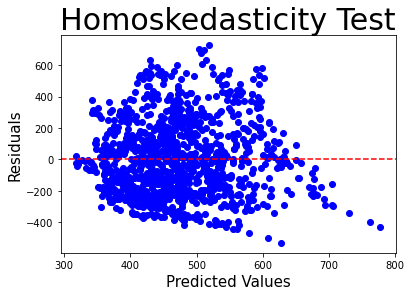

In [3]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [4]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(dataset['income']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))


# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 25.768438815718504, 'LM p-val': 2.5377837229185637e-06, 'F-Stat': 13.145156363736128, 'F p-val': 2.2676423377302845e-06}
{'LM-Stat': 16.98578277589019, 'LM p-val': 3.766077082686958e-05, 'F-Stat': 17.210444785499845, 'F p-val': 3.5926842191214453e-05}


In [5]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

0.0892005541889206


In [6]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects
exog = sm.tools.tools.add_constant(dataset['income'])
endog = dataset['violent']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
#print results
print(re_res)
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                violent   R-squared:                        0.1101
Estimator:              RandomEffects   R-squared (Between):              0.0745
No. Observations:                1150   R-squared (Within):               0.1116
Date:                Sat, Apr 09 2022   R-squared (Overall):              0.0791
Time:                        17:22:53   Log-likelihood                   -6730.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      141.97
Entities:                          50   P-value                           0.0000
Avg Obs:                       23.000   Distribution:                  F(1,1148)
Min Obs:                       23.000                                           
Max Obs:                       23.000   F-statistic (robust):             141.97
                            

In [7]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov


In [8]:
df = b[np.abs(b) < 1e8].size

chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
pval = stats.chi2.sf(chi2, df)
return chi2, df, pval
hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

NameError: name 'b' is not defined